### Importación de librerias


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import glob
from scipy.signal import butter, filtfilt, welch, detrend
from statsmodels.nonparametric.smoothers_lowess import lowess
from skimage.restoration import denoise_nl_means, estimate_sigma

### Funciones de filtrado

In [2]:
def filtro_wavelet(signal, wavelet='db4', nivel=6):
    # Nivel bajo para evitar reducción excesiva de tamaño
    max_nivel = min(nivel, pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len))
    coeffs = pywt.wavedec(signal, wavelet, level=max_nivel)
    coeffs[0] = np.zeros_like(coeffs[0])
    sigma_est = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma_est * np.sqrt(2 * np.log(len(signal)))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    rec = pywt.waverec(coeffs, wavelet)
    # Asegura que la señal tenga el mismo tamaño
    if len(rec) > len(signal):
        rec = rec[:len(signal)]
    return rec

def filtro_pasabajas(signal, fs=500, cutoff=50, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return filtfilt(b, a, signal)

def filtro_pasaaltas(signal, fs=500, cutoff=0.5, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='high')
    return filtfilt(b, a, signal)

def filtro_loess(signal, frac=0.01):
    if len(signal) < 2:
        return signal
    result = lowess(signal, np.arange(len(signal)), frac=frac, return_sorted=False)
    if np.any(np.isnan(result)):
        result = np.where(np.isnan(result), signal, result)
    return result

def filtro_nlm_1d(signal, k=7):
    if np.any(np.isnan(signal)):
        signal = np.nan_to_num(signal)
    return np.convolve(signal, np.ones(k)/k, mode='same')



### Funciones de flujo de procesamiento


In [3]:
def flujo1(signal, fs=500):
    return filtro_pasabajas(filtro_wavelet(filtro_pasaaltas(signal, fs), 'db4'), fs)

def flujo2(signal, fs=500):
    return filtro_pasabajas(filtro_wavelet(detrend(signal), 'db4'), fs)

def flujo3(signal, fs=500):
    s1 = filtro_pasabajas(signal, fs)
    s2 = filtro_loess(s1)
    return filtro_nlm_1d(s2)



### Cargar y seleccionar señales

In [ ]:
def cargar_derivacion_II(ruta_archivo):
    data = np.genfromtxt(ruta_archivo, delimiter=',', skip_header=1)
    return data[:, 1]  # derivación II

# Ruta correcta a tu carpeta ECG
ruta_carpeta = 'ECGData/*.csv'

# Cargar los archivos
lista_archivos = glob.glob(ruta_carpeta)
print(f"Se encontraron {len(lista_archivos)} archivos.")

# Selección aleatoria
np.random.seed(42)
archivos_10 = np.random.choice(lista_archivos, size=10, replace=False)



Se encontraron 10646 archivos.


### Procesamiento por flujo y cálculo de fMP

MUSE_20180111_165814_46000.csv - len(f3): 5000, NaNs: 0, min: -190.598048339436, max: 215.24293421264318


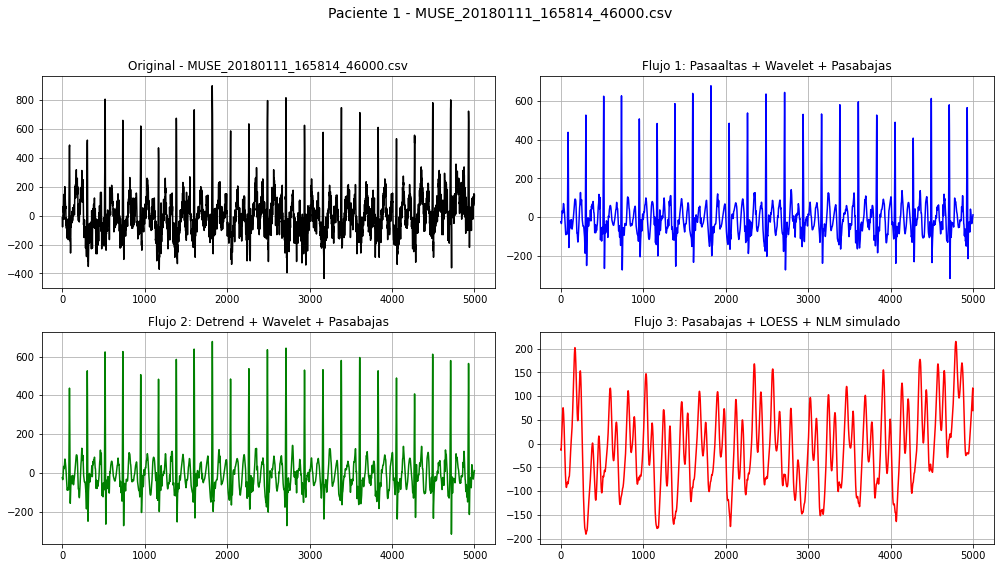

MUSE_20180114_121142_54000.csv - len(f3): 5000, NaNs: 0, min: -96.03455329435297, max: 392.8522533012676


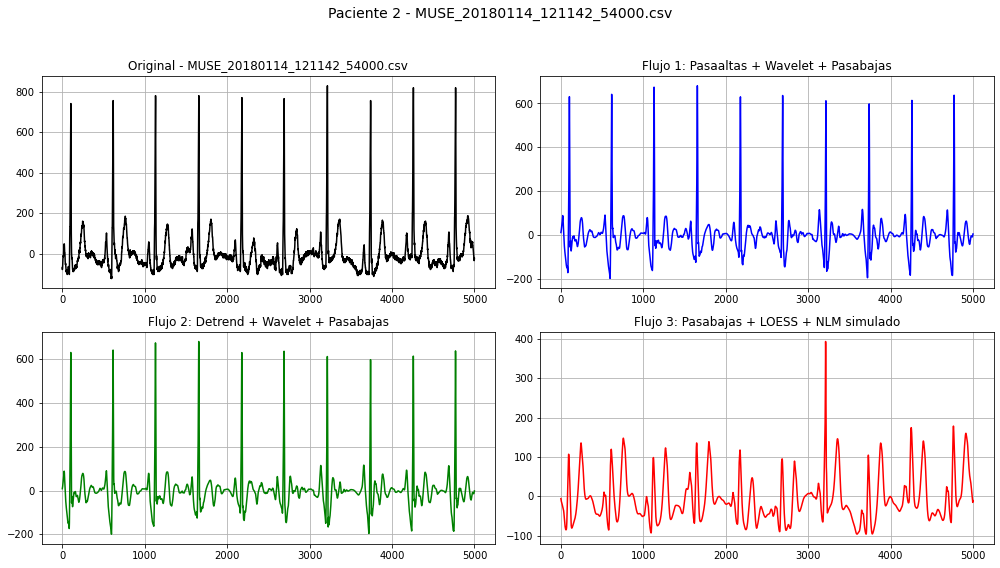

MUSE_20180712_151451_06000.csv - len(f3): 5000, NaNs: 0, min: -225.1090598813002, max: 209.12255292463993


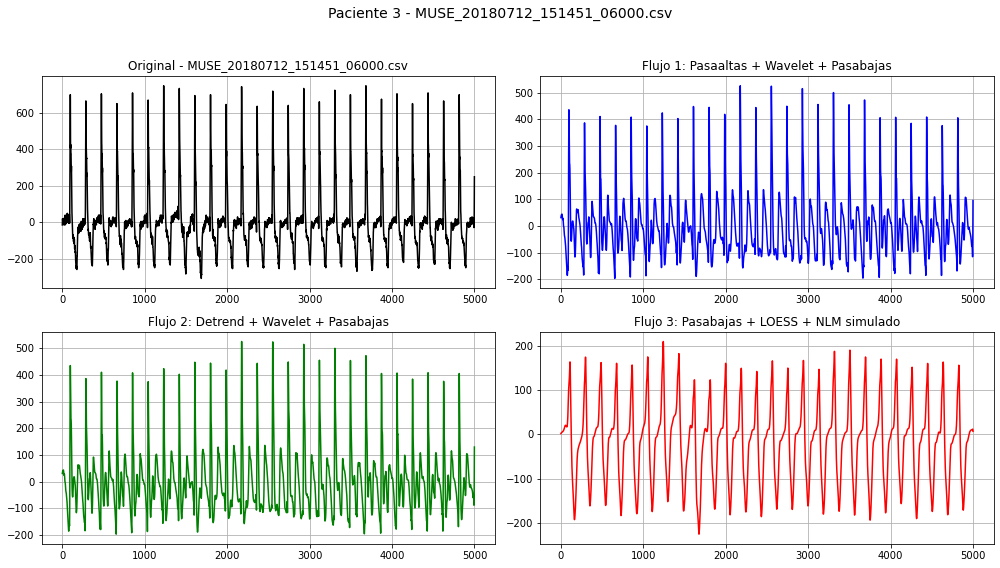

MUSE_20180114_072329_74000.csv - len(f3): 5000, NaNs: 0, min: -181.93810681737227, max: 274.97306365911265


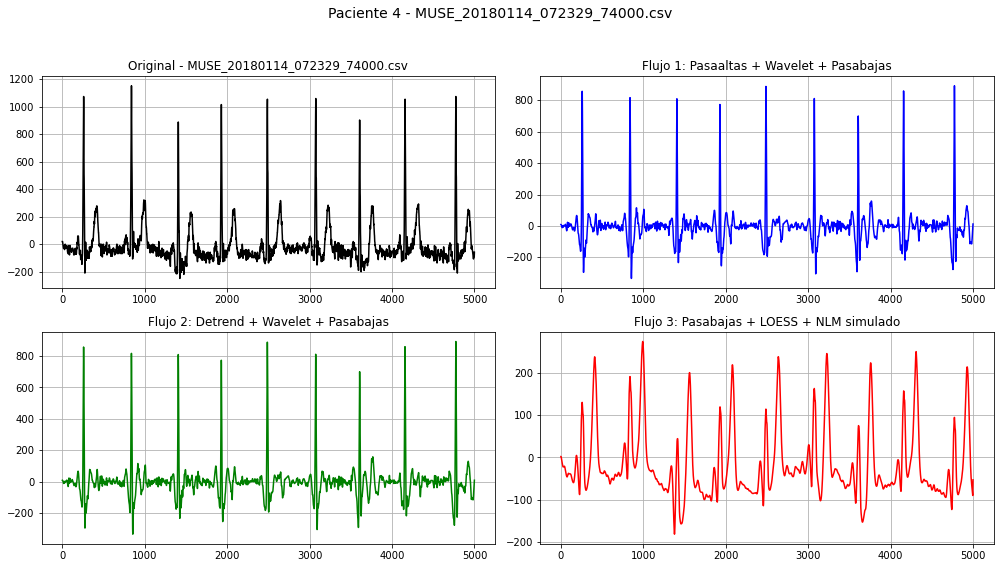

MUSE_20180209_171534_23000.csv - len(f3): 5000, NaNs: 0, min: -138.6954020665279, max: 223.69825956120587


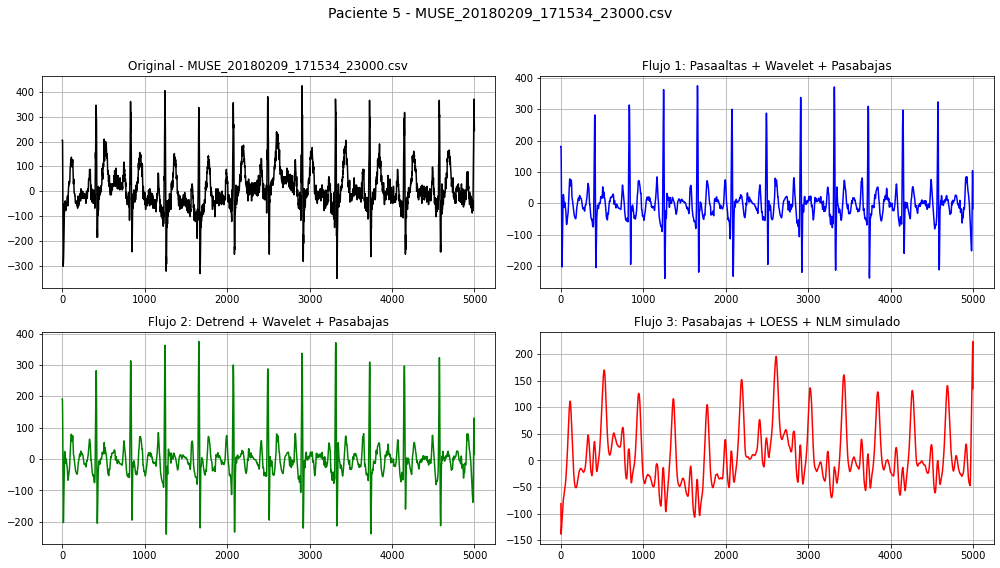

MUSE_20180111_165639_72000.csv - len(f3): 5000, NaNs: 0, min: -151.0354507986211, max: 177.1205797846814


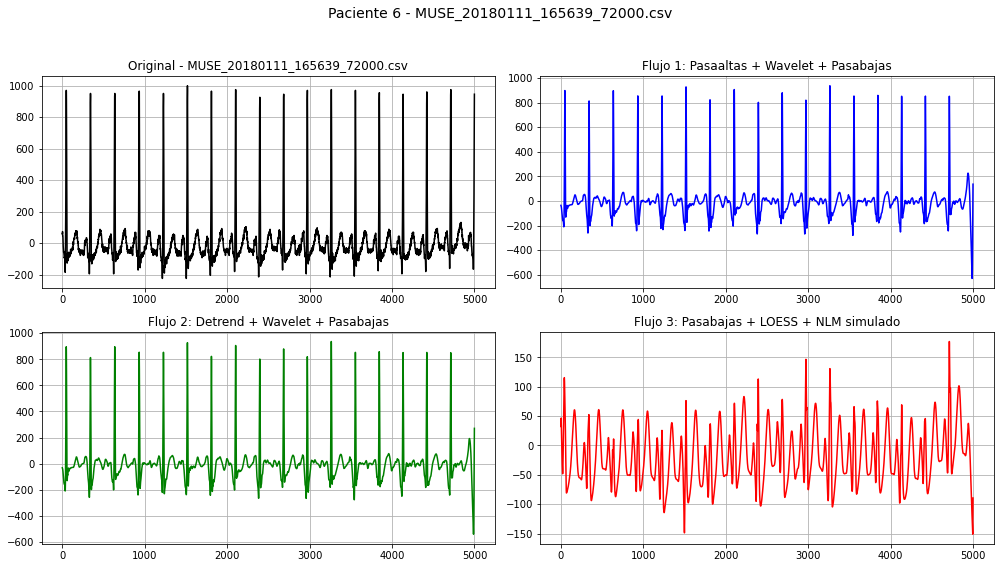

MUSE_20180210_115759_28000.csv - len(f3): 5000, NaNs: 0, min: -141.44836364823686, max: 343.90953540638037


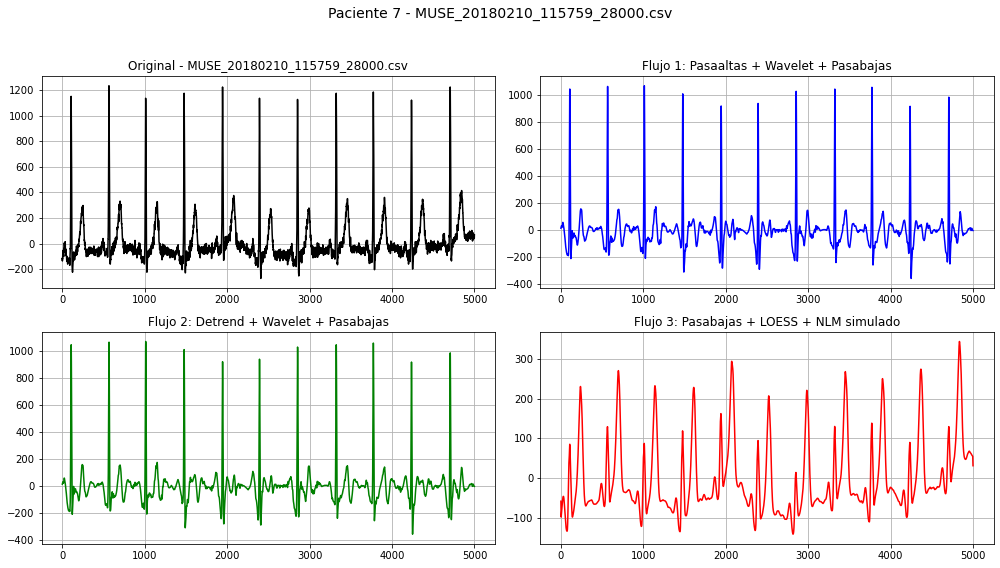

MUSE_20180114_074926_01000.csv - len(f3): 5000, NaNs: 0, min: -451.16555294231955, max: 928.7415519003348


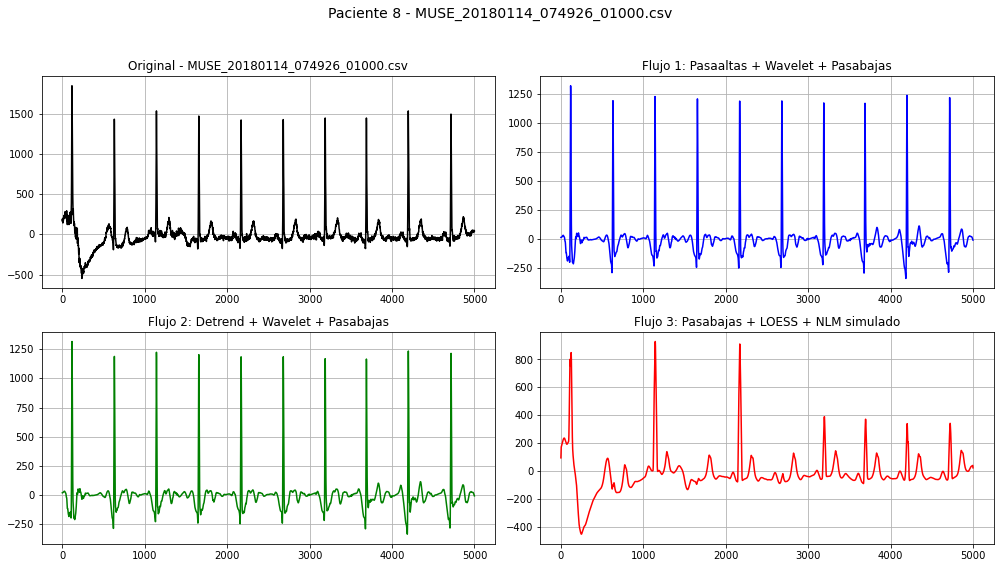

MUSE_20180113_130048_24000.csv - len(f3): 5000, NaNs: 0, min: -147.2687258821089, max: 149.01663212561482


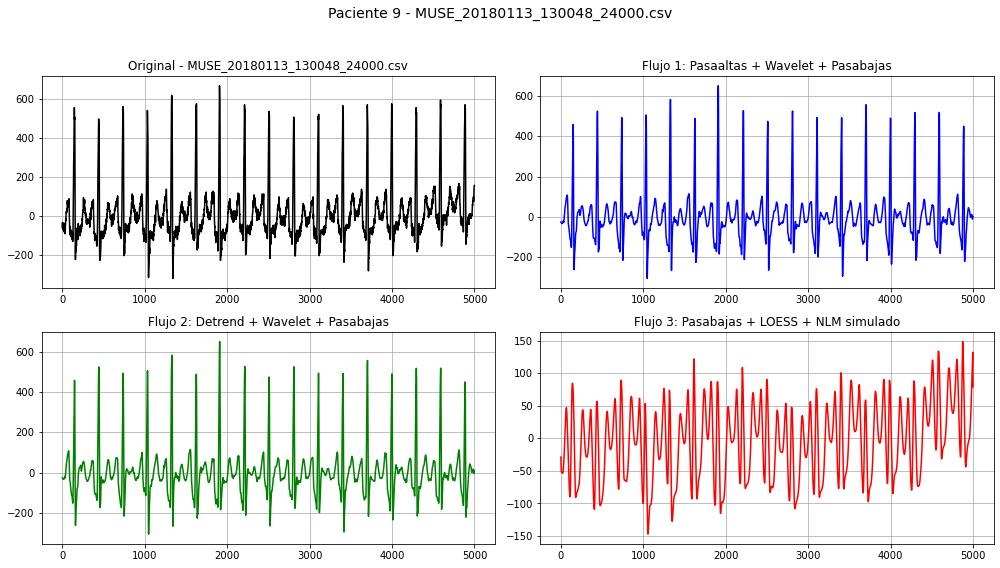

MUSE_20180120_122216_77000.csv - len(f3): 5000, NaNs: 0, min: -142.40869906787248, max: 386.44882017673496


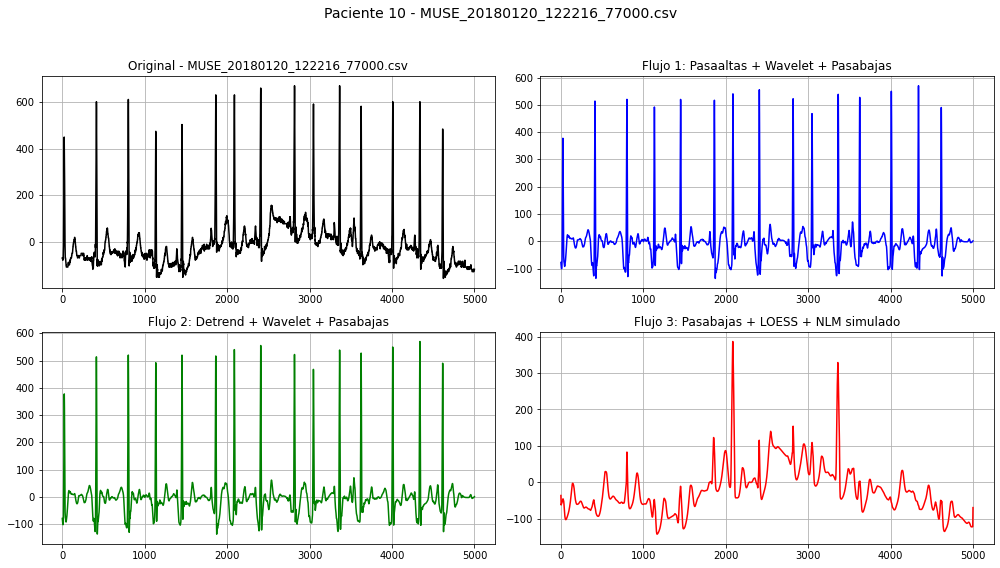

In [39]:
def calcular_fMP(signal, fs=500):
    # Robustez: chequea que la señal sea válida
    if signal is None or len(signal) == 0 or np.all(np.isnan(signal)):
        return np.nan
    f, Pxx = welch(signal, fs)
    if len(Pxx) == 0:
        return np.nan
    return f[np.argmax(Pxx)]

resultados = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)

    # Aplicar flujos (¡robustos!)
    f1 = flujo1(ecg)
    f2 = flujo2(ecg)
    f3 = flujo3(ecg)
    
    # Diagnóstico para f3 (puedes comentar después de probar)
    print(f"{nombre} - len(f3): {len(f3)}, NaNs: {np.isnan(f3).sum()}, min: {np.nanmin(f3)}, max: {np.nanmax(f3)}")
    
    # Calcular fMP
    fmp1 = calcular_fMP(f1)
    fmp2 = calcular_fMP(f2)
    fmp3 = calcular_fMP(f3)
    resultados.append((nombre, estado, fmp1, fmp2, fmp3))
    
    # Graficar
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    plt.plot(ecg, color='black')
    plt.title(f"Original - {nombre}")
    plt.grid(True)
    plt.subplot(2, 2, 2)
    plt.plot(f1, color='blue')
    plt.title("Flujo 1: Pasaaltas + Wavelet + Pasabajas")
    plt.grid(True)
    plt.subplot(2, 2, 3)
    plt.plot(f2, color='green')
    plt.title("Flujo 2: Detrend + Wavelet + Pasabajas")
    plt.grid(True)
    plt.subplot(2, 2, 4)
    plt.plot(f3, color='red')
    plt.title("Flujo 3: Pasabajas + LOESS + NLM simulado")
    plt.grid(True)
    plt.suptitle(f"Paciente {i+1} - {nombre}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [40]:
df_resultados = pd.DataFrame(resultados, columns=["Registro", "Estado", "fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"])
display(df_resultados)

df_resultados.to_csv("resultados_flujos.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujos.csv'")

,Registro,Estado,fMP_Flujo1,fMP_Flujo2,fMP_Flujo3
0,MUSE_20180111_165814_46000.csv,MUSE,7.812500,7.812500,1.953125
1,MUSE_20180114_121142_54000.csv,MUSE,5.859375,5.859375,3.906250
2,MUSE_20180712_151451_06000.csv,MUSE,5.859375,5.859375,1.953125
3,MUSE_20180114_072329_74000.csv,MUSE,7.812500,7.812500,1.953125
4,MUSE_20180209_171534_23000.csv,MUSE,7.812500,7.812500,1.953125
5,MUSE_20180111_165639_72000.csv,MUSE,9.765625,9.765625,3.906250
6,MUSE_20180210_115759_28000.csv,MUSE,7.812500,7.812500,1.953125
7,MUSE_20180114_074926_01000.csv,MUSE,5.859375,5.859375,3.906250
8,MUSE_20180113_130048_24000.csv,MUSE,5.859375,5.859375,5.859375
9,MUSE_20180120_122216_77000.csv,MUSE,7.812500,7.812500,3.906250


✔ Resultados guardados como 'resultados_flujos.csv'


Media y desviación estándar de fMP por flujo:
fMP_Flujo1: media=7.23, std=1.32, min=5.86, max=9.77
fMP_Flujo2: media=7.23, std=1.32, min=5.86, max=9.77
fMP_Flujo3: media=3.12, std=1.37, min=1.95, max=5.86

Valores atípicos (fuera de 1.5 * IQR):
fMP_Flujo1: 0 valores atípicos.
fMP_Flujo2: 0 valores atípicos.
fMP_Flujo3: 0 valores atípicos.


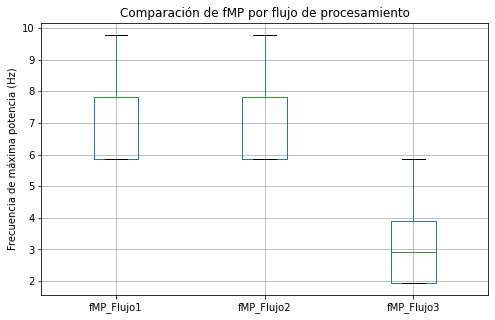

In [41]:

# Estadística descriptiva
print("Media y desviación estándar de fMP por flujo:")
for col in ["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]:
    media = df_resultados[col].mean()
    std = df_resultados[col].std()
    min_ = df_resultados[col].min()
    max_ = df_resultados[col].max()
    print(f"{col}: media={media:.2f}, std={std:.2f}, min={min_:.2f}, max={max_:.2f}")

# Detección de valores atípicos (outliers simples)
print("\nValores atípicos (fuera de 1.5 * IQR):")
for col in ["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]:
    Q1 = df_resultados[col].quantile(0.25)
    Q3 = df_resultados[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_resultados[(df_resultados[col] < Q1 - 1.5*IQR) | (df_resultados[col] > Q3 + 1.5*IQR)][col]
    print(f"{col}: {len(outliers)} valores atípicos.")

# Boxplot para comparar flujos
plt.figure(figsize=(8,5))
df_resultados[["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]].boxplot()
plt.ylabel("Frecuencia de máxima potencia (Hz)")
plt.title("Comparación de fMP por flujo de procesamiento")
plt.grid(True)
plt.show()


Con base en la comparación visual del boxplot, el Flujo 1 es el más adecuado para el procesamiento de las señales ECG. Presenta valores de frecuencia de máxima potencia (fMP) dentro de un rango fisiológico esperado, similar al Flujo 2 pero con menor dispersión. Por el contrario, el Flujo 3 tiende a producir valores considerablemente menores, lo que sugiere un exceso de suavizado y posible pérdida de información relevante de la señal. Por ello, para el resto del trabajo se selecciona el Flujo 1, que garantiza una mejor preservación de las características espectrales y morfológicas del ECG.

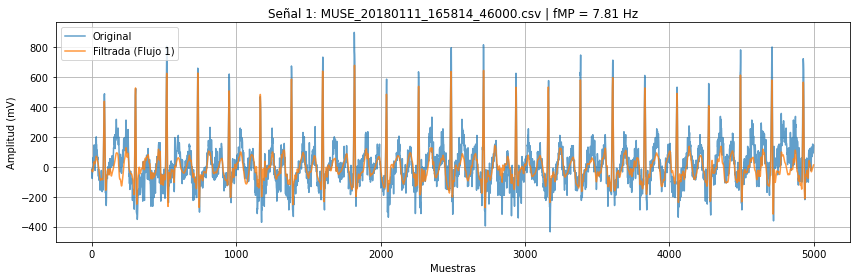

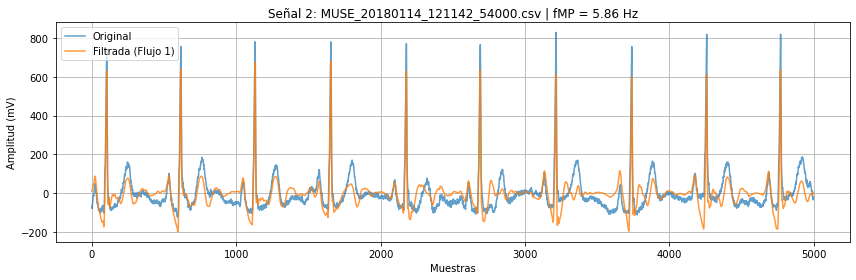

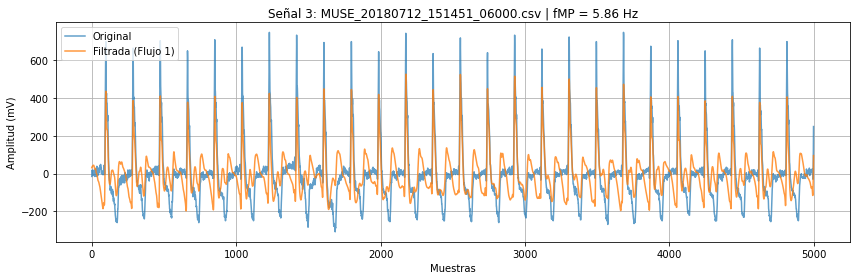

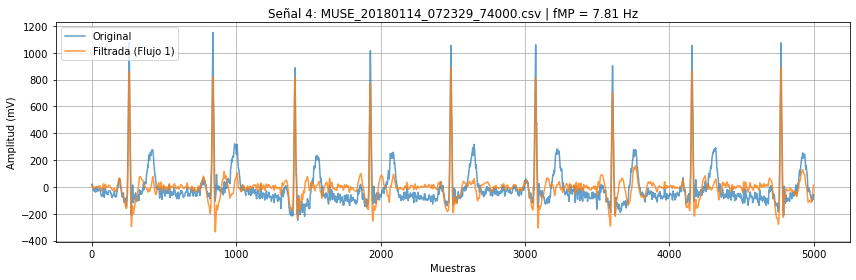

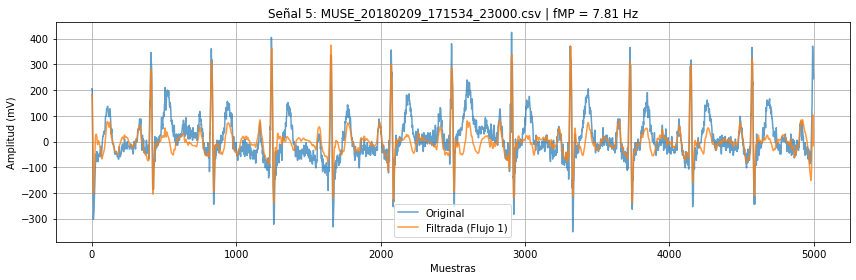

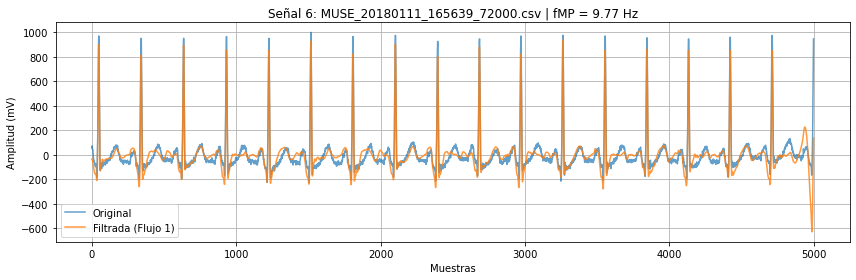

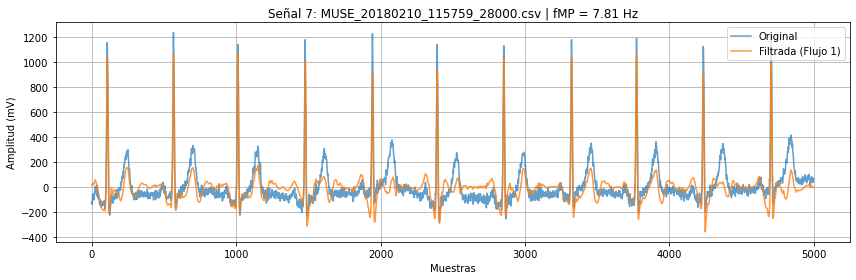

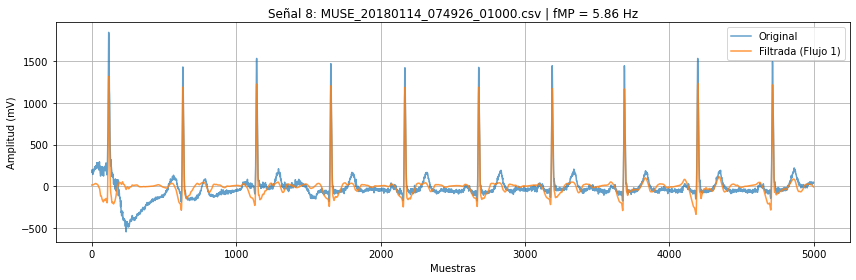

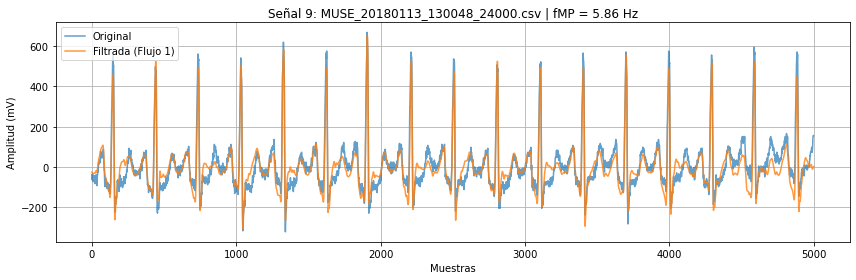

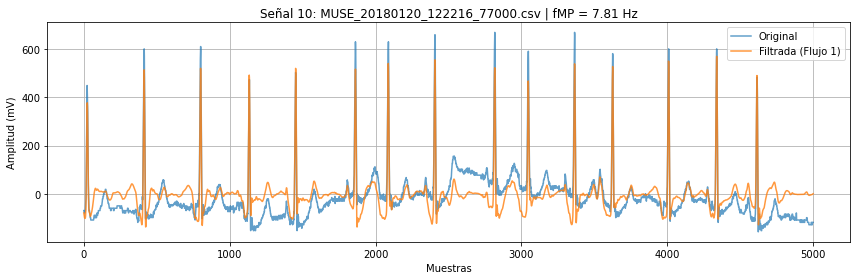

,Registro,Estado,fMP
0,MUSE_20180111_165814_46000.csv,MUSE,7.812500
1,MUSE_20180114_121142_54000.csv,MUSE,5.859375
2,MUSE_20180712_151451_06000.csv,MUSE,5.859375
3,MUSE_20180114_072329_74000.csv,MUSE,7.812500
4,MUSE_20180209_171534_23000.csv,MUSE,7.812500
5,MUSE_20180111_165639_72000.csv,MUSE,9.765625
6,MUSE_20180210_115759_28000.csv,MUSE,7.812500
7,MUSE_20180114_074926_01000.csv,MUSE,5.859375
8,MUSE_20180113_130048_24000.csv,MUSE,5.859375
9,MUSE_20180120_122216_77000.csv,MUSE,7.812500


✔ Resultados guardados como 'resultados_flujo1.csv'


In [42]:
resultados_flujo1 = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)
    
    # Procesar con Flujo 1
    ecg_filtrada = flujo1(ecg)
    
    # Calcular frecuencia de máxima potencia
    fmp = calcular_fMP(ecg_filtrada)
    resultados_flujo1.append((nombre, estado, fmp))
    
    # Graficar original y filtrada
    plt.figure(figsize=(12, 4))
    plt.plot(ecg, label="Original", alpha=0.7)
    plt.plot(ecg_filtrada, label="Filtrada (Flujo 1)", alpha=0.8)
    plt.title(f"Señal {i+1}: {nombre} | fMP = {fmp:.2f} Hz")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud (mV)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Guardar resultados
df_flujo1 = pd.DataFrame(resultados_flujo1, columns=["Registro", "Estado", "fMP"])
display(df_flujo1)

df_flujo1.to_csv("resultados_flujo1.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujo1.csv'")


In [43]:
# Asumiendo que ya tienes tu DataFrame de diagnóstico:
df_diag = pd.read_excel("Diagnostics.xlsx")  # Ajusta el nombre si es distinto

# Procesar las 10 señales seleccionadas
resultados_flujo1 = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)
    
    ecg_filtrada = flujo1(ecg)
    fmp = calcular_fMP(ecg_filtrada)
    resultados_flujo1.append((nombre, estado, fmp))

df_flujo1 = pd.DataFrame(resultados_flujo1, columns=["Registro", "Estado", "fMP"])

# Unir con la columna de diagnóstico
df_flujo1 = df_flujo1.merge(df_diag, on="Registro", how="left")
df_flujo1 = df_flujo1.rename(columns={"Diagnóstico": "Tipo de patología"})  # Cambia si tu Excel usa otro nombre

display(df_flujo1)
df_flujo1.to_csv("resultados_flujo1_10senales.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujo1_10senales.csv'")

KeyError: 'Registro'

Punto 6: Creación de rutina y procesamiento de todas las señales

In [ ]:
import os
from glob import glob
# Función única de procesamiento (flujo 1) y extracción de fMP
def procesar_senal(signal, fs=500, wavelet='db4', level=4):
    # 1. Pasaaltas IIR
    b1, a1 = butter(4, 0.5 / (fs / 2), btype='high')
    signal = filtfilt(b1, a1, signal)
    
    # 2. Wavelet modificado
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # suprimir detalles
    signal = pywt.waverec(coeffs, wavelet)
    
    # 3. Pasabajas IIR
    b2, a2 = butter(4, 50 / (fs / 2), btype='low')
    signal = filtfilt(b2, a2, signal)
    
    # 4. Welch para fMP
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    idx_max = np.argmax(Pxx)
    fmp = f[idx_max]
    
    return fmp

# Procesamiento de todos los archivos
#carpeta = "./ECGData"
ruta_carpeta = "ECGData"
archivos = glob(os.path.join(ruta_carpeta, "*.csv"))
print(f" Total archivos encontrados: {len(archivos)}")
fs = 500

resultados = []

for ruta in archivos:
    try:
        nombre_archivo = os.path.basename(ruta)
        registro = os.path.splitext(nombre_archivo)[0]
        señal = cargar_derivacion_II(ruta)

        fmp = procesar_senal(señal, fs)

        # Extraer Estado desde nombre si es posible
        estado = registro.split("_")[1] if "_" in registro else "Desconocido"
        resultados.append({"Registro": registro, "Estado": estado, "FMP": fmp})
    
    except Exception as e:
        print(f"Error procesando {ruta}: {e}")

# Crear y guardar DataFrame
df_fmp = pd.DataFrame(resultados)
df_fmp.to_excel("Resultados_FMP_Proyecto3.xlsx", index=False)
print("Exportación completada correctamente.")

🔍 Total archivos encontrados: 10646
Exportación completada correctamente.


Verificamos el archivo que cabos de crear

In [ ]:
# Cargar el archivo Excel generado
df_fmp = pd.read_excel("Resultados_FMP_Proyecto3.xlsx")

# Limpiar posibles espacios en los nombres de columnas
df_fmp.columns = df_fmp.columns.str.strip()

# Mostrar las columnas encontradas
print("📄 Columnas del archivo:")
print(df_fmp.columns.tolist())

# Verificar columnas esperadas
esperadas = {"Registro", "Estado", "FMP"}
actuales = set(df_fmp.columns)

if esperadas.issubset(actuales):
    print(" La estructura del archivo es correcta.")
else:
    print("El archivo NO tiene la estructura esperada.")
    print("Faltan columnas:", esperadas - actuales)

# Mostrar total de registros
print(f" Total de registros procesados: {len(df_fmp)}")

# Mostrar un resumen general
print("\n Resumen estadístico de fMP:")
print(df_fmp["FMP"].describe())

# Verificar si hay valores faltantes
print("\n Valores faltantes por columna:")
print(df_fmp.isnull().sum())

# Mostrar los primeros 5 registros
print("\n Primeros 5 registros:")
print(df_fmp.head())

📄 Columnas del archivo:
['Registro', 'Estado', 'FMP']
 La estructura del archivo es correcta.
 Total de registros procesados: 10646

 Resumen estadístico de fMP:
count    10646.000000
mean         3.202356
std          2.185112
min          0.488281
25%          0.976562
50%          2.929688
75%          4.394531
max         13.671875
Name: FMP, dtype: float64

 Valores faltantes por columna:
Registro    0
Estado      0
FMP         0
dtype: int64

 Primeros 5 registros:
                     Registro    Estado       FMP
0  MUSE_20180111_155115_19000  20180111  1.953125
1  MUSE_20180111_155154_74000  20180111  4.882812
2  MUSE_20180111_155203_15000  20180111  3.906250
3  MUSE_20180111_155249_70000  20180111  1.953125
4  MUSE_20180111_155542_84000  20180111  3.417969


In [ ]:
import pandas as pd

# 1. Cargar archivo de resultados fMP
df_fmp = pd.read_excel("Resultados_FMP_Proyecto3.xlsx")
df_fmp.columns = df_fmp.columns.str.strip()

# 2. Cargar archivo de diagnóstico desde Excel
df_diag = pd.read_excel("Diagnostics.xlsx")
df_diag.columns = df_diag.columns.str.strip()

# 3. Renombrar columnas para facilitar el merge (ajusta si tienen otros nombres)
df_diag = df_diag.rename(columns={"FileName": "Registro", "Rhythm": "Arritmia"})

# 4. Hacer el merge por la columna "Registro"
df_merged = df_fmp.merge(df_diag[["Registro", "Arritmia"]], on="Registro", how="left")

# 5. Reemplazar columna "Estado" por la nueva
df_merged = df_merged.drop(columns=["Estado"])
df_merged = df_merged.rename(columns={"Arritmia": "Estado"})

# 6. Guardar resultado final
df_merged.to_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx", index=False)
print(" Archivo final con diagnóstico de arritmia generado correctamente.")

# 7. Mostrar resumen de asignación
num_nan = df_merged["Estado"].isna().sum()
if num_nan > 0:
    print(f" {num_nan} registros no tienen diagnóstico asociado.")
else:
    print(" Todos los registros tienen su tipo de arritmia asignado.")

✅ Archivo final con diagnóstico de arritmia generado correctamente.
 Todos los registros tienen su tipo de arritmia asignado.


Verificamos la estructura del nuevo archivo

In [ ]:
# Cargar el archivo generado
df_final = pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")
df_final.columns = df_final.columns.str.strip()  # limpiar nombres

# Mostrar nombres de columnas
print(" Columnas del archivo:")
print(df_final.columns.tolist())

# Total de registros
print(f"\n Total de registros: {len(df_final)}")

# Primeras 5 filas
print("\n Primeros 5 registros:")
print(df_final.head())

# Conteo por tipo de arritmia
print("\n Conteo por tipo de arritmia:")
print(df_final["Estado"].value_counts(dropna=False))

# Verificar valores faltantes
print("\n Valores faltantes por columna:")
print(df_final.isnull().sum())

 Columnas del archivo:
['Registro', 'FMP', 'Estado']

 Total de registros: 10646

 Primeros 5 registros:
                     Registro       FMP Estado
0  MUSE_20180111_155115_19000  1.953125     ST
1  MUSE_20180111_155154_74000  4.882812   AFIB
2  MUSE_20180111_155203_15000  3.906250   AFIB
3  MUSE_20180111_155249_70000  1.953125     ST
4  MUSE_20180111_155542_84000  3.417969     AF

 Conteo por tipo de arritmia:
SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Estado, dtype: int64

 Valores faltantes por columna:
Registro    0
FMP         0
Estado      0
dtype: int64


Concuerda con los datos registrados en el primer proyecto

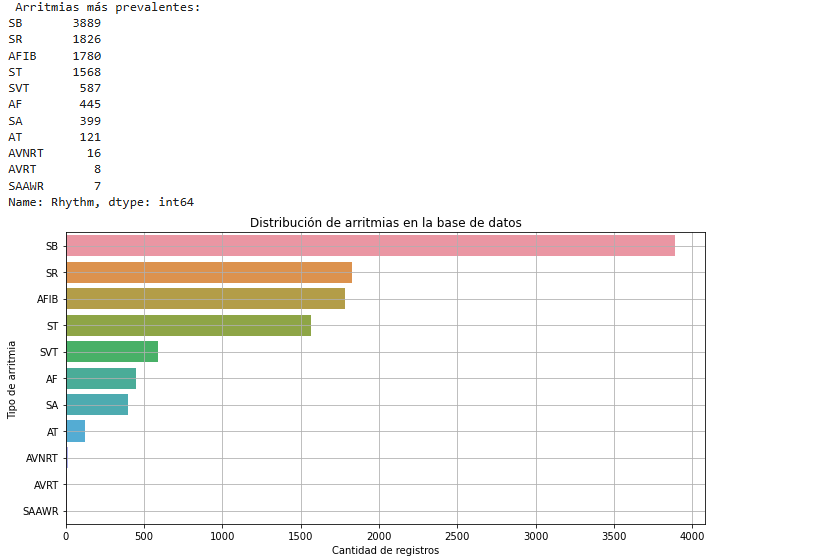

fMP a las señales filtradas, para compara con lo obtenido hasta el momento 

In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
from scipy.signal import welch

# 1. Función para cargar derivación II desde archivos ya filtrados
def cargar_derivacion_II_denoised(ruta_archivo):
    data = np.genfromtxt(ruta_archivo, delimiter=',', skip_header=1)
    return data[:, 1]  # segunda columna = derivación II

# 2. Función para obtener fMP con Welch
def obtener_fmp(signal, fs=500):
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    return f[np.argmax(Pxx)]

# 3. Recorrer archivos .csv en ECGDataDenoised/
ruta_denoised = "ECGDataDenoised"
archivos_denoised = glob(os.path.join(ruta_denoised, "*.csv"))
print(f" Archivos encontrados en ECGDataDenoised: {len(archivos_denoised)}")

resultados_denoised = []

for ruta in archivos_denoised:
    try:
        nombre = os.path.basename(ruta)
        registro = os.path.splitext(nombre)[0]
        senal = cargar_derivacion_II_denoised(ruta)
        
        if len(senal) == 0:
            print(f" Señal vacía: {registro}")
            continue
        
        fmp = obtener_fmp(senal)
        resultados_denoised.append({"Registro": registro, "FMP_denoised": fmp})
    
    except Exception as e:
        print(f" Error procesando {ruta}: {type(e).__name__} → {e}")

# 4. Crear DataFrame con los resultados
df_denoised = pd.DataFrame(resultados_denoised)

# 5. Cargar archivo Diagnostics.xlsx para asignar arritmia
df_diag = pd.read_excel("Diagnostics.xlsx")
df_diag.columns = df_diag.columns.str.strip()
df_diag = df_diag.rename(columns={"FileName": "Registro", "Rhythm": "Estado"})

# 6. Unir fMP_denoised con arritmias
df_denoised = df_denoised.merge(df_diag[["Registro", "Estado"]], on="Registro", how="left")

# 7. Guardar resultado
df_denoised.to_excel("Resultados_FMP_Denoised_con_arritmia.xlsx", index=False)
print(" Archivo Resultados_FMP_Denoised_con_arritmia.xlsx creado correctamente.")

 Archivos encontrados en ECGDataDenoised: 10646
 Error procesando ECGDataDenoised\MUSE_20180113_124215_52000.csv: ValueError → Some errors were detected !
    Line #1926 (got 5 columns instead of 12)
 Archivo Resultados_FMP_Denoised_con_arritmia.xlsx creado correctamente.


Verificacion del archivo creado

In [ ]:
# Cargar archivo generado
df_denoised = pd.read_excel("Resultados_FMP_Denoised_con_arritmia.xlsx")
df_denoised.columns = df_denoised.columns.str.strip()

# Ver columnas presentes
print(" Columnas del archivo:")
print(df_denoised.columns.tolist())

# Total de registros
print(f"\n Total de registros: {len(df_denoised)}")

# Primeras 5 filas
print("\n Primeros 5 registros:")
print(df_denoised.head())

# Conteo por tipo de arritmia
print("\n Conteo por tipo de arritmia:")
print(df_denoised["Estado"].value_counts(dropna=False))

# Verificación de valores faltantes
print("\n Valores faltantes por columna:")
print(df_denoised.isnull().sum())

 Columnas del archivo:
['Registro', 'FMP_denoised', 'Estado']

 Total de registros: 10645

 Primeros 5 registros:
                     Registro  FMP_denoised Estado
0  MUSE_20180111_155115_19000      1.953125     ST
1  MUSE_20180111_155154_74000      4.882812   AFIB
2  MUSE_20180111_155203_15000      3.906250   AFIB
3  MUSE_20180111_155249_70000      1.953125     ST
4  MUSE_20180111_155542_84000      3.417969     AF

 Conteo por tipo de arritmia:
SB       3888
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Estado, dtype: int64

 Valores faltantes por columna:
Registro        0
FMP_denoised    0
Estado          0
dtype: int64


Analisis comparativo

 Registros emparejados: 10645

 Estadísticas Descriptivas:
con procesamiento --- Media = 3.20 Hz, Desv = 2.19 Hz
Denoised previo --- Media = 4.02 Hz, Desv = 2.53 Hz

 t-test pareado --- t = -37.474, p = 8.190e-289
 Hay una diferencia estadísticamente significativa entre los fMP.


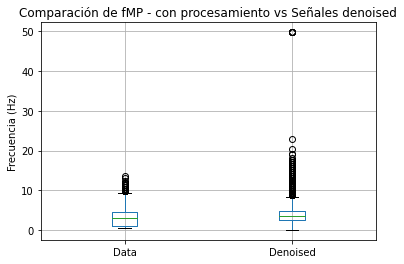

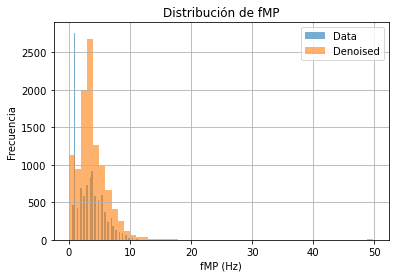

In [ ]:
from scipy.stats import ttest_rel


# 1. Cargar ambos archivos
df_data = pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")
df_denoised = pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")

# 2. Limpiar columnas
df_data.columns = df_data.columns.str.strip()
df_denoised.columns = df_denoised.columns.str.strip()

# 3. Unir DataFrames por Registro
df_cmp = df_data.merge(df_denoised[["Registro", "FMP_denoised"]], on="Registro", how="inner")

print(f" Registros emparejados: {len(df_cmp)}")

# 4. Estadísticas descriptivas
mean_data = df_cmp["FMP"].mean()
std_data  = df_cmp["FMP"].std()
mean_denoised = df_cmp["FMP_denoised"].mean()
std_denoised  = df_cmp["FMP_denoised"].std()

print("\n Estadísticas Descriptivas:")
print(f"con procesamiento --- Media = {mean_data:.2f} Hz, Desv = {std_data:.2f} Hz")
print(f"Denoised previo --- Media = {mean_denoised:.2f} Hz, Desv = {std_denoised:.2f} Hz")

# 5. Prueba de hipótesis: t-test pareado
stat, p_value = ttest_rel(df_cmp["FMP"], df_cmp["FMP_denoised"])
print(f"\n t-test pareado --- t = {stat:.3f}, p = {p_value:.3e}")

if p_value < 0.05:
    print(" Hay una diferencia estadísticamente significativa entre los fMP.")
else:
    print(" No hay diferencia significativa entre los fMP.")

# 6. Gráficas comparativas

# Boxplot
plt.figure()
df_cmp[["FMP", "FMP_denoised"]].boxplot()
plt.title("Comparación de fMP - con procesamiento vs Señales denoised")
plt.ylabel("Frecuencia (Hz)")
plt.xticks([1, 2], ["Data", "Denoised"])
plt.grid(True)
plt.show()

# Histograma
plt.figure()
plt.hist(df_cmp["FMP"], bins=50, alpha=0.6, label="Data")
plt.hist(df_cmp["FMP_denoised"], bins=50, alpha=0.6, label="Denoised")
plt.xlabel("fMP (Hz)")
plt.ylabel("Frecuencia")
plt.title("Distribución de fMP")
plt.legend()
plt.grid(True)
plt.show()

t-test pareado
Es una prueba estadística que compara las medias de dos muestras relacionadas, en este caso:

fMP obtenido con tu procesamiento (Flujo 1)

fMP obtenido desde las señales ECGDataDenoised

La relación es que ambas muestras provienen de la misma señal (Registro), pero procesadas de dos formas distintas. Por eso se usa una prueba pareada y no independiente.

- H₀ (nula): No hay diferencia entre los valores de fMP procesados por ti y los denoised (media de las diferencias = 0).

- H₁ (alternativa): Sí hay una diferencia significativa en los fMP obtenidos por los dos métodos.

In [56]:
from scipy.stats import shapiro

# Shapiro-Wilk
stat1, p1 = shapiro(df_cmp["FMP"])
stat2, p2 = shapiro(df_cmp["FMP_denoised"])

print("📊 Shapiro-Wilk:")
print(f"Tu procesamiento → W = {stat1:.3f}, p = {p1:.3e}")
print(f"Denoised previo → W = {stat2:.3f}, p = {p2:.3e}")

📊 Shapiro-Wilk:
Tu procesamiento → W = 0.913, p = 0.000e+00
Denoised previo → W = 0.794, p = 0.000e+00


Shapiro-Wilk
Ambos p-values son < 0.0001, lo que rechaza la hipótesis nula de normalidad.

Por lo tanto no podemos aplicar pruebas que asuman normalidad

In [67]:
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu

# 1. Cargar los dos archivos
df_data= pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")
df_denoised = pd.read_excel("Resultados_FMP_Denoised_con_arritmia.xlsx")

# 2. Limpiar nombres de columnas
df_data.columns = df_data.columns.str.strip()
df_denoised.columns = df_denoised.columns.str.strip()

# 3. Hacer merge por Registro
df_cmp = df_data.merge(df_denoised[["Registro", "FMP_denoised"]], on="Registro", how="inner")

# 4. Aplicar prueba de Wilcoxon (pareada)
stat_wilcoxon, p_wilcoxon = wilcoxon(df_cmp["FMP"], df_cmp["FMP_denoised"])
print(" Wilcoxon Signed-Rank Test :")
print(f"Statistic = {stat_wilcoxon:.3f}, p-value = {p_wilcoxon:.3e}")
if p_wilcoxon < 0.05:
    print(" Diferencia significativa entre métodos.")
else:
    print(" No hay diferencia significativa.")

# 5. Aplicar Mann–Whitney U (no pareada, solo por comparación)
stat_mann, p_mann = mannwhitneyu(df_cmp["FMP"], df_cmp["FMP_denoised"], alternative="two-sided")
print("\nMann–Whitney U Test:")
print(f"Statistic = {stat_mann:.3f}, p-value = {p_mann:.3e}")
if p_mann < 0.05:
    print(" Diferencia significativa según Mann–Whitney")
else:
    print(" Coincide: no hay diferencia significativa según Mann–Whitney.")

 Wilcoxon Signed-Rank Test :
Statistic = 570424.000, p-value = 0.000e+00
 Diferencia significativa entre métodos.

Mann–Whitney U Test:
Statistic = 44623111.000, p-value = 2.830e-160
 Diferencia significativa según Mann–Whitney


Mann–Whitney U:  No es la ideal en este caso, porque se usa para muestras independientes, no emparejadas. Sin emabargo se utilizó como metodo de confirmación

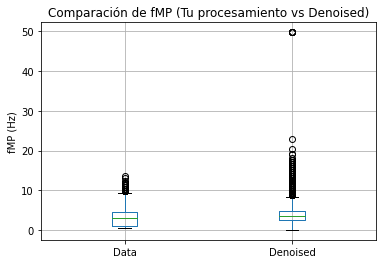

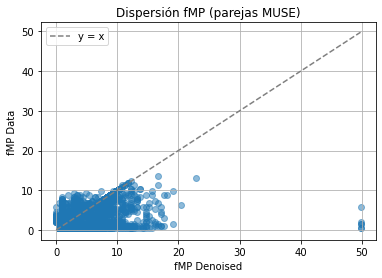

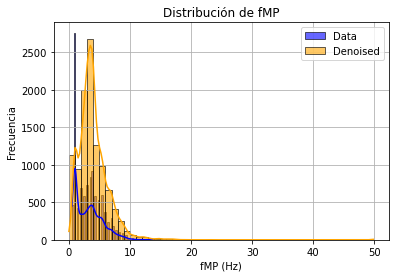

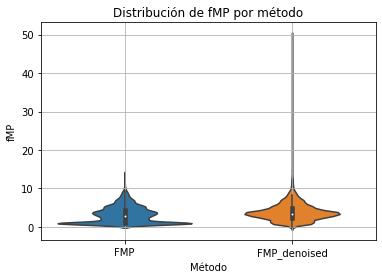

<Figure size 720x360 with 0 Axes>

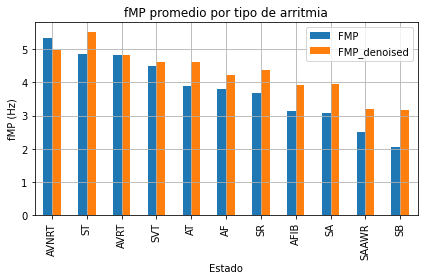

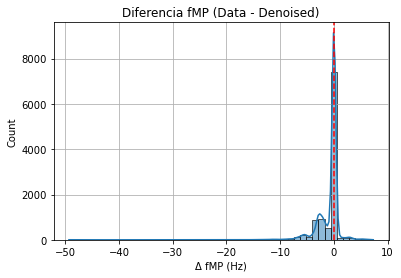

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asumiendo que df_cmp contiene: Registro, FMP, FMP_denoised, Estado

# 1️ Boxplot pareado
plt.figure()
df_cmp[["FMP", "FMP_denoised"]].boxplot()
plt.title("Comparación de fMP (Tu procesamiento vs Denoised)")
plt.ylabel("fMP (Hz)")
plt.xticks([1, 2], ["Data", "Denoised"])
plt.grid(True)
plt.show()

# 2 Scatter plot fMP vs fMP_denoised
plt.figure()
plt.scatter(df_cmp["FMP_denoised"], df_cmp["FMP"], alpha=0.5)
plt.plot([0, max(df_cmp["FMP_denoised"].max(), df_cmp["FMP"].max())],
         [0, max(df_cmp["FMP_denoised"].max(), df_cmp["FMP"].max())],
         linestyle='--', color='gray', label="y = x")
plt.xlabel("fMP Denoised")
plt.ylabel("fMP Data")
plt.title("Dispersión fMP (parejas MUSE)")
plt.legend()
plt.grid(True)
plt.show()

# 3 Histogramas superpuestos
plt.figure()
sns.histplot(df_cmp["FMP"], bins=50, kde=True, color="blue", label="Data", alpha=0.6)
sns.histplot(df_cmp["FMP_denoised"], bins=50, kde=True, color="orange", label="Denoised", alpha=0.6)
plt.xlabel("fMP (Hz)")
plt.ylabel("Frecuencia")
plt.title("Distribución de fMP")
plt.legend()
plt.grid(True)
plt.show()

# 4️ Violin plot por método
df_plot = df_cmp.melt(id_vars="Registro", value_vars=["FMP", "FMP_denoised"], var_name="Método", value_name="fMP")
plt.figure()
sns.violinplot(x="Método", y="fMP", data=df_plot)
plt.title("Distribución de fMP por método")
plt.grid(True)
plt.show()

# 5️ Barras por tipo de arritmia
plt.figure(figsize=(10,5))
mean_fmp = df_cmp.groupby("Estado")[["FMP", "FMP_denoised"]].mean().sort_values("FMP", ascending=False)
mean_fmp.plot(kind="bar")
plt.title("fMP promedio por tipo de arritmia")
plt.ylabel("fMP (Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6️ Histograma de diferencias (Data - denoised)
plt.figure()
delta = df_cmp["FMP"] - df_cmp["FMP_denoised"]
sns.histplot(delta, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Diferencia fMP (Data - Denoised)")
plt.xlabel("Δ fMP (Hz)")
plt.grid(True)
plt.show()

Boxplot pareado: Compara las distribuciones de fMP obtenidas con tu flujo de procesamiento (FMP) y las del conjunto ECGDataDenoised (FMP_denoised). Permite observar diferencias en mediana (línea dentro del cuadro), dispersión (altura de la caja y longitud de los bigotes), outliers (puntos atípicos)

Scatter plot (dispersión pareada): Cada punto es una señal. Muestra la relación uno a uno entre los dos métodos y se traza una línea diagonal y = x como referencia perfecta. Si todos los puntos están cerca de la línea, ambos métodos dan resultados similares y si hay un sesgo sistemático (todos por encima o debajo), tu método sobreestima o subestima fMP respecto al denoised.

Histogramas superpuestos con KDE: Distribución global de los fMP con ambos métodos. Revela asimetrías, modas múltiples, diferencias de forma. KDE = curva suavizada que representa densidad. Si una distribución está más desplazada hacia la derecha, ese método tiende a entregar mayores fMP y si son muy distintas en forma, los métodos no solo cambian escala sino también el patrón de frecuencia.

Violin plot: Distribución completa y densidad de probabilidad de los fMP por método. Combina la precisión del boxplot con la forma del histograma y muestra simetría/asimetría de la densidad, aplanamiento o concentración. Diferencias en grosor y forma indican cómo se distribuyen los valores más probables en cada método.

Barras agrupadas por tipo de arritmia: fMP promedio de cada método, agrupado por el tipo de ritmo/arritmia (Estado). Nos da idea de como cambia la fMP dependiendo de la arritmia y permite ver si tu método capta diferencias más claras o más suaves entre tipos de ritmo.

 Histograma de diferencia fMP: indica la diferencia directa de fMP entre ambos métodos, señal por señal. dice si el método tiende a aumentar o disminuir el fMP. El histograma centrado en 0 indicaría neutralidad. Desplazado indica sesgo sistemático.


Analisis de concordancia señal por señal

 Pearson correlation: r = 0.549, p = 0.000e+00


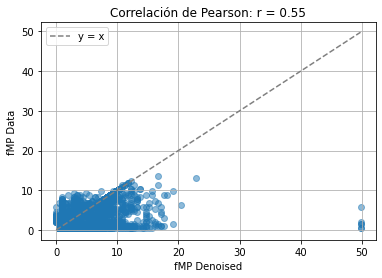

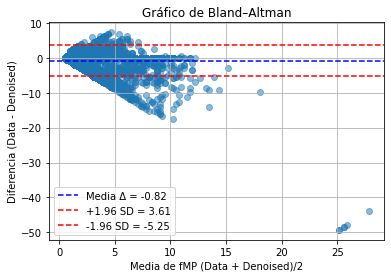

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Cargar ambos archivos y fusionarlos
df_data = pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")
df_denoised = pd.read_excel("Resultados_FMP_Denoised_con_arritmia.xlsx")

df_data.columns = df_data.columns.str.strip()
df_denoised.columns = df_denoised.columns.str.strip()

df_cmp = df_data.merge(df_denoised[["Registro", "FMP_denoised"]], on="Registro", how="inner")

#  1. Correlación de Pearson

r, p = pearsonr(df_cmp["FMP"], df_cmp["FMP_denoised"])
print(f" Pearson correlation: r = {r:.3f}, p = {p:.3e}")

# Gráfico de dispersión con línea de identidad
plt.figure()
plt.scatter(df_cmp["FMP_denoised"], df_cmp["FMP"], alpha=0.5)
plt.plot([df_cmp["FMP_denoised"].min(), df_cmp["FMP_denoised"].max()],
         [df_cmp["FMP_denoised"].min(), df_cmp["FMP_denoised"].max()],
         color='gray', linestyle='--', label='y = x')
plt.xlabel("fMP Denoised")
plt.ylabel("fMP Data")
plt.title(f"Correlación de Pearson: r = {r:.2f}")
plt.legend()
plt.grid(True)
plt.show()


# 2. Bland–Altman plot
df_cmp["Media"] = (df_cmp["FMP"] + df_cmp["FMP_denoised"]) / 2
df_cmp["Diferencia"] = df_cmp["FMP"] - df_cmp["FMP_denoised"]
mean_diff = df_cmp["Diferencia"].mean()
std_diff = df_cmp["Diferencia"].std()

# Límites de concordancia
lim_sup = mean_diff + 1.96 * std_diff
lim_inf = mean_diff - 1.96 * std_diff

# Gráfico de Bland–Altman
plt.figure()
plt.scatter(df_cmp["Media"], df_cmp["Diferencia"], alpha=0.5)
plt.axhline(mean_diff, color='blue', linestyle='--', label=f"Media Δ = {mean_diff:.2f}")
plt.axhline(lim_sup, color='red', linestyle='--', label=f"+1.96 SD = {lim_sup:.2f}")
plt.axhline(lim_inf, color='red', linestyle='--', label=f"-1.96 SD = {lim_inf:.2f}")
plt.xlabel("Media de fMP (Data + Denoised)/2")
plt.ylabel("Diferencia (Data - Denoised)")
plt.title("Gráfico de Bland–Altman")
plt.legend()
plt.grid(True)
plt.show()

 Análisis de Correlación de Pearson
Se evaluó la relación lineal entre los valores de frecuencia de máxima potencia (fMP) obtenidos mediante el flujo de procesamiento propuesto y aquellos derivados de las señales previamente filtradas (ECGDataDenoised). El coeficiente de correlación de Pearson fue r = 0.549, con un valor p significativamente bajo (p < 0.001), lo que indica una correlación positiva moderada y estadísticamente significativa entre ambos métodos.

El gráfico de dispersión muestra una tendencia general ascendente, es decir, a medida que aumenta el fMP en el método denoised, también tiende a aumentar en el flujo propuesto. Sin embargo, también se observa que muchos puntos están alejados de la línea de identidad (y = x), especialmente en el rango bajo de fMP, lo que indica que aunque los métodos están relacionados, no son completamente equivalentes en su cuantificación del fMP.

Análisis de Concordancia: Bland–Altman
El gráfico de Bland–Altman evalúa la concordancia señal por señal entre ambos métodos. Se observa que la diferencia promedio entre los métodos es de −0.82 Hz, lo que indica un sesgo sistemático leve: el flujo propuesto tiende a reportar fMP ligeramente menores que las señales denoised.

Los límites de concordancia calculados fueron de +3.61 Hz y −5.25 Hz, lo que implica que el 95% de las diferencias entre métodos caen dentro de ese rango. Aunque la mayoría de los puntos se concentran dentro de los límites, se observa una dispersión más amplia hacia valores medios y altos de fMP, lo que podría indicar menor precisión del flujo propuesto en señales con mayor contenido espectral.

Además, la distribución de las diferencias no es completamente homogénea a lo largo del eje X (media de fMP), lo que sugiere que la variabilidad del sesgo puede depender del valor promedio de fMP, especialmente para señales por encima de los 10 Hz, donde comienzan a aparecer más valores atípicos. siendo despues de 25 donde aoarecen los valores que más atipicos